## Stage 3: CNN Classifier
The manual approach, yielded some positive results
Let's see if a machine learning algorithm using similar information might also work

**Plan:**

Chord Qualities:
1. Compute the summed frequency array, and note bin arrays
2. Put these into a CNN (try different combinations)
3. Try a few other models, including:
    - random forest
    - hmm
    - knn

Root Notes:
1. Given the calculated quality and frequency volume, try to work out what the root note is

In [19]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm
import tensorflow_io as tfio

TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [20]:
def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-4.,oct_range_to=8.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def plot_notes(fileName):
    """convert the fft image from file to notes notations and plot on"""
    #print(fileName)
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.)) 
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for rnote in range(12):
        vol_matrix[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
        
    plt.bar(NOTES, vol_matrix)
    plt.show()

In [21]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [5]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal

scheme = ["min", "maj", "dim", "aug"]

def load_wav_16k_mono(filename):
    sample_rate, wav_data = wav.read(filename)
    if wav_data.ndim > 1:
        wav_data = wav_data[:, 0]
    return wav_data, sample_rate

def preprocess(file_path, label):
    wav_data, sample_rate = load_wav_16k_mono(file_path)
    wav_data = wav_data[:48000]
    zero_padding = np.zeros(48000 - len(wav_data), dtype=np.float32)
    wav_data = np.concatenate([zero_padding, wav_data])
    spectrogram = np.abs(signal.stft(wav_data, nperseg=320, noverlap=288)[2])
    
    # Add an extra dimension to the spectrogram before resizing
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    # Ensure the spectrogram has the correct dimensions
    spectrogram = tf.image.resize(spectrogram, [300, 500])

    # crop the image

    # set the one-hot encoding of the label
    quality_one_hot = [0,0,0,0]
    for i in range(len(scheme)):
        if scheme[i] == label:
            quality_one_hot[i] = 1

    return spectrogram, quality_one_hot


In [6]:
spectrogram, label = preprocess(train_set['File Path'].iloc[1], train_set['Quality'].iloc[1])


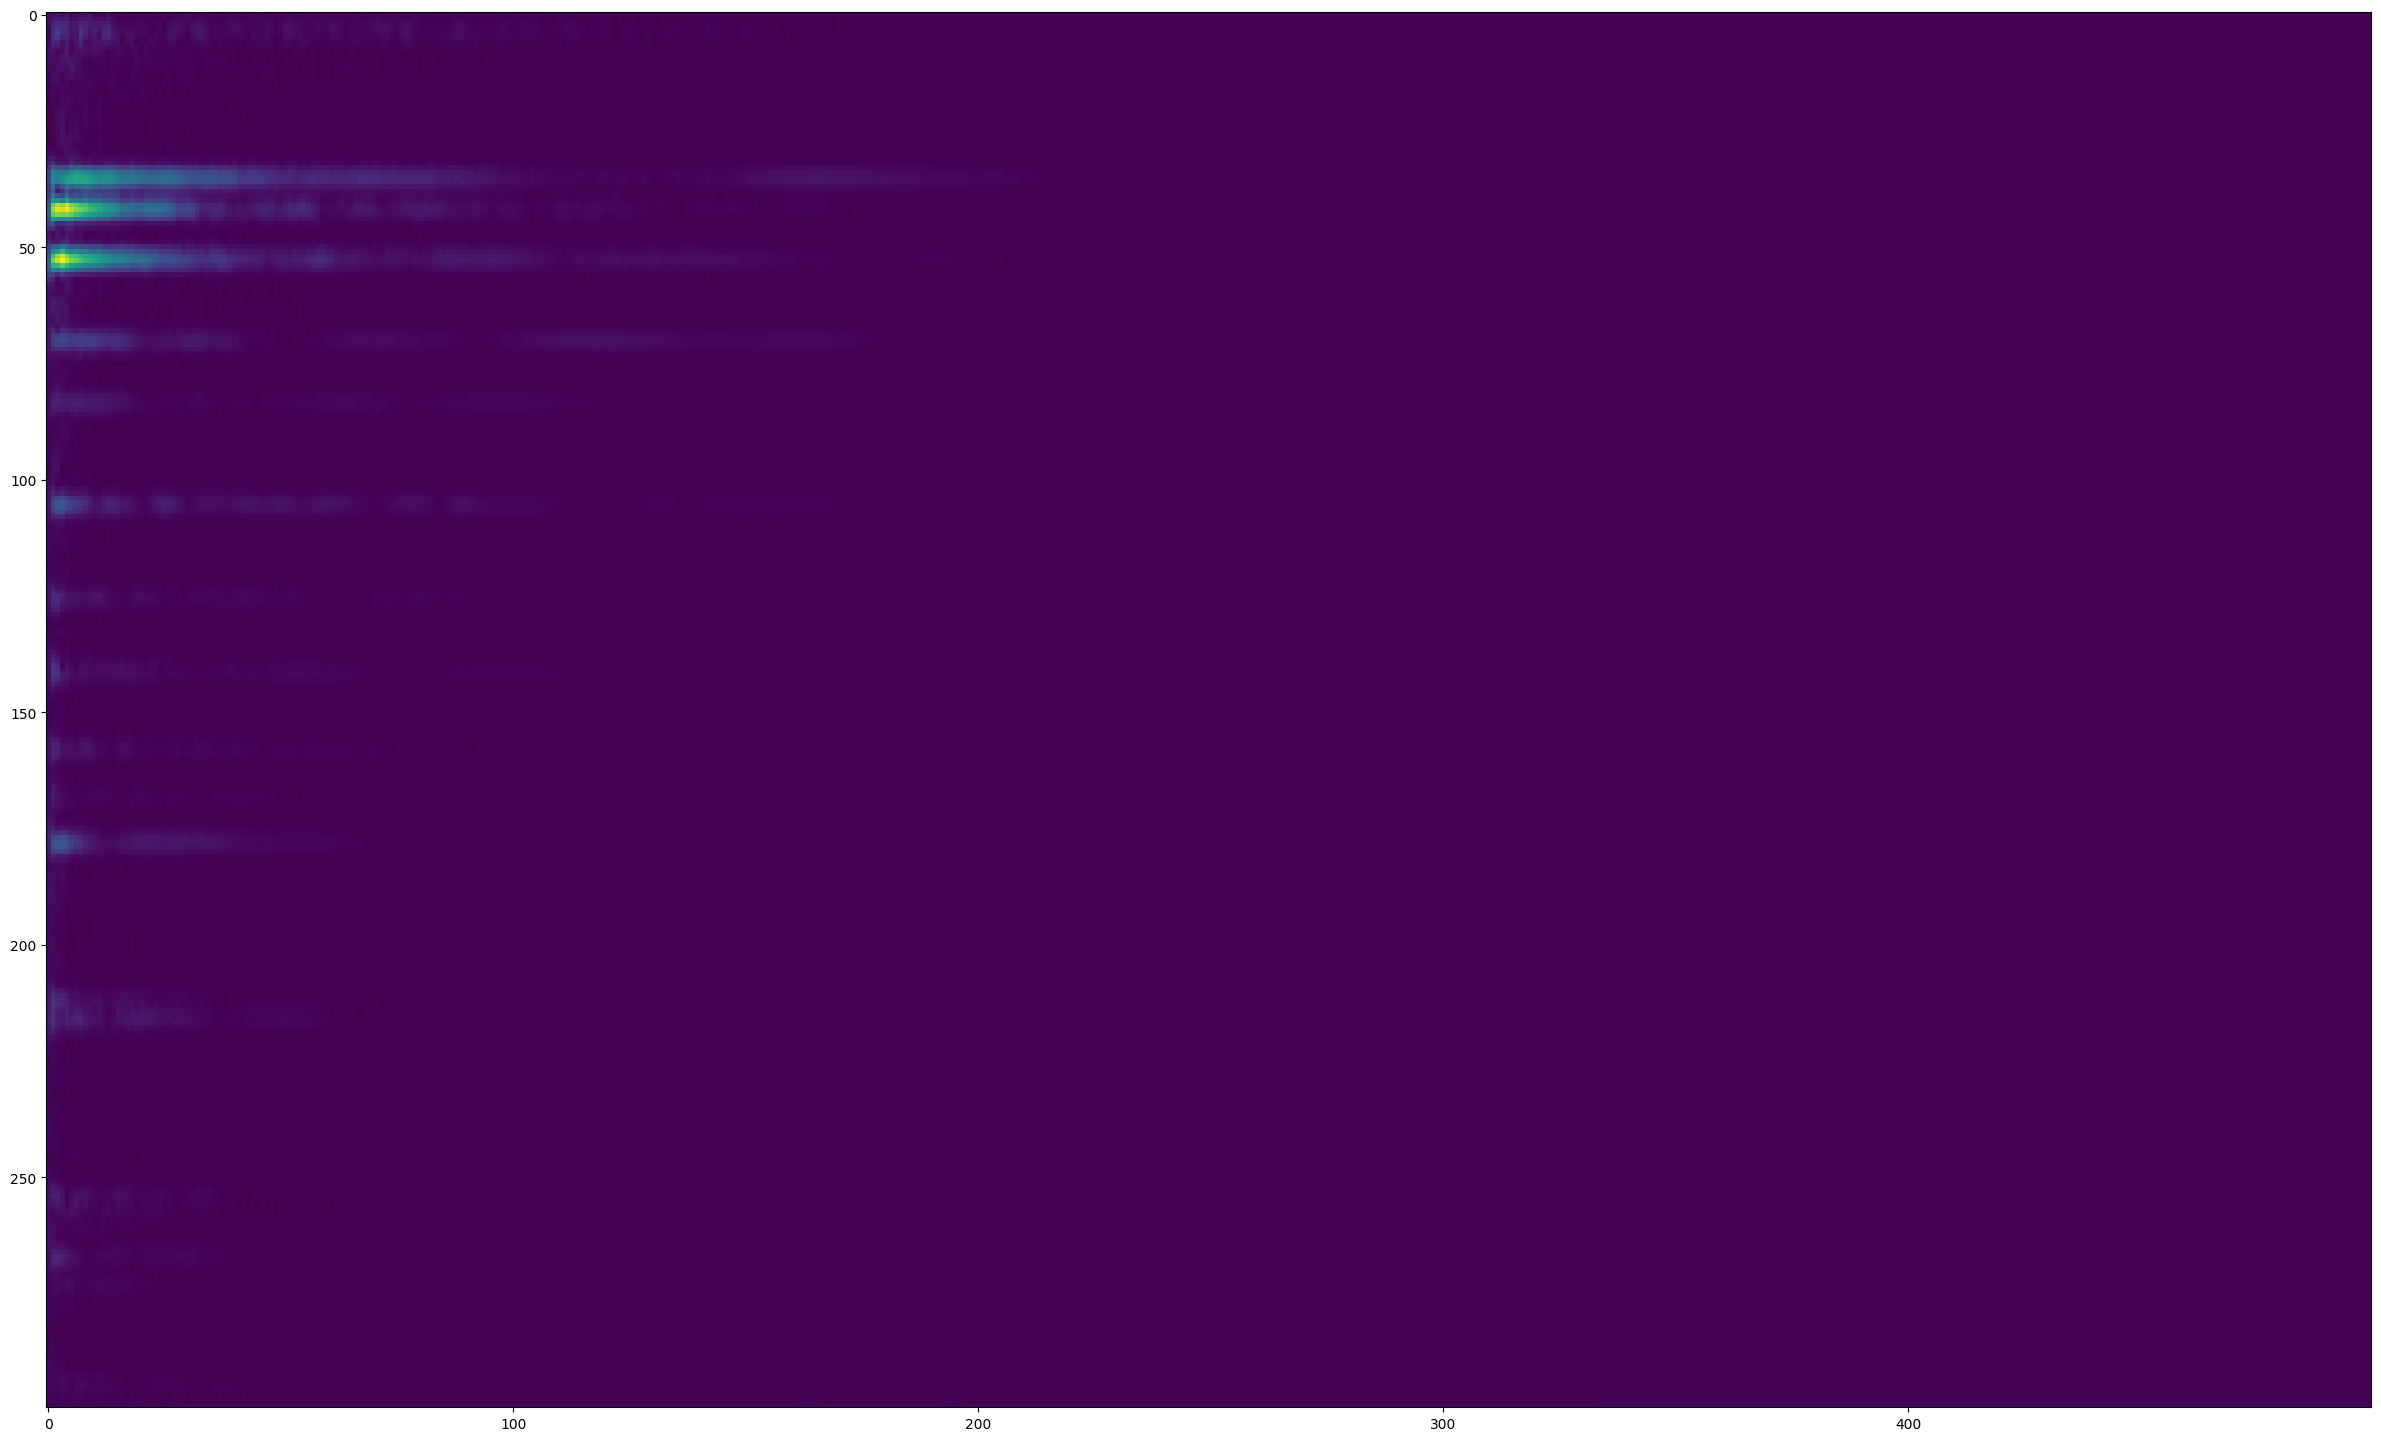

In [7]:
plt.figure(figsize=(30,20))
plt.imshow(spectrogram)
plt.show()

In [313]:
# test the model on the test_set

# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator
def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4605 - loss: 4.3380
Test loss: 4.65. Test accuracy: 41.37%


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split

# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


In [23]:
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

In [24]:
# Assuming you have loaded your data into X_train, y_train, X_test, y_test
# Adjust the data loading according to your specific dataset.

# Split the data into training and validation sets
# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))

train_dataset = dataset.take(int(0.8 * 713))
val_dataset = dataset.skip(int(0.8 * 713))

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 500, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with a validation set
history = model.fit(
    train_dataset,
    epochs=10, batch_size=32,
    validation_data=val_dataset
)

Epoch 1/10
570/570 [==============================] - 23s 40ms/step - loss: 15.1393 - accuracy: 0.2737 - val_loss: 1.3896 - val_accuracy: 0.2448
Epoch 2/10
570/570 [==============================] - 23s 41ms/step - loss: 1.2887 - accuracy: 0.4509 - val_loss: 1.3588 - val_accuracy: 0.3217
Epoch 3/10
570/570 [==============================] - 23s 41ms/step - loss: 1.0014 - accuracy: 0.5965 - val_loss: 1.4388 - val_accuracy: 0.3007
Epoch 4/10
570/570 [==============================] - 23s 41ms/step - loss: 0.8919 - accuracy: 0.7386 - val_loss: 1.3303 - val_accuracy: 0.3916
Epoch 5/10
570/570 [==============================] - 24s 41ms/step - loss: 0.4788 - accuracy: 0.8684 - val_loss: 1.2106 - val_accuracy: 0.4685
Epoch 6/10
570/570 [==============================] - 25s 43ms/step - loss: 0.1348 - accuracy: 0.9667 - val_loss: 1.5762 - val_accuracy: 0.4545
Epoch 7/10
570/570 [==============================] - 26s 45ms/step - loss: 0.0186 - accuracy: 0.9965 - val_loss: 1.4222 - val_accuracy

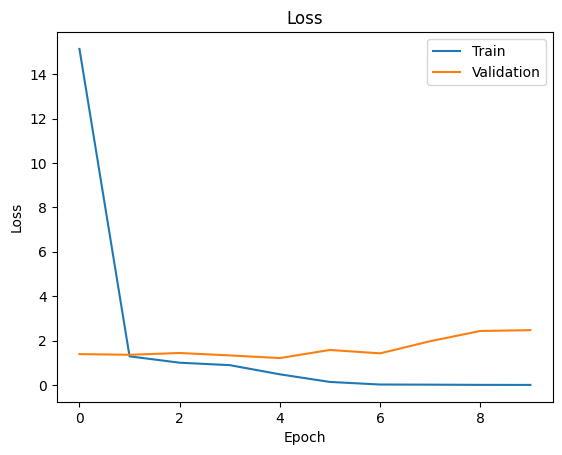

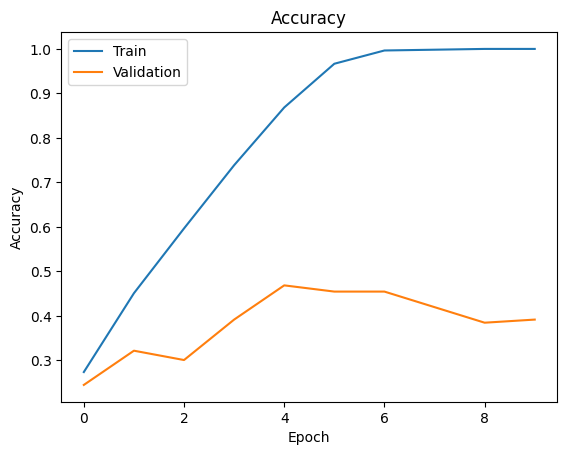

In [26]:
# make a plot of the training and validation loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()


In [27]:
# test the model on the test_set

# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator
def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 [==============================] - 3s 8ms/step - loss: 2.5995 - accuracy: 0.4137
Test loss: 2.60. Test accuracy: 41.37%


In [32]:
# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator

def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 [==============================] - 3s 8ms/step - loss: 2.0562 - accuracy: 0.4463
Test loss: 2.06. Test accuracy: 44.63%
